In [ ]:
!pip3 install pmdarima

In [ ]:
# Import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


warnings.simplefilter('ignore')

In [ ]:
data = pd.read_csv('Dataset5_yearssn.csv',names = ['yearssn'])


**Applying KPSS and ADF test**

1. ADF test

In [ ]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = data[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('yearssn')

Results of Dickey-Fuller Test for  yearssn 

Test Statistic                  -2.845522
p-value                          0.052060
#Lags Used                       8.000000
Number of Observations Used    305.000000
Critical Value (1%)             -3.451974
Critical Value (5%)             -2.871063
Critical Value (10%)            -2.571844
dtype: float64


2. KPSS test

In [ ]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(atr):
    timeseries = data[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('yearssn')

Results of KPSS Test for  yearssn
Test Statistic            0.414735
p-value                   0.070804
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For ADF test, we can see that the p-value  is more than 0.05. Thus, from ADF test, we can say that the dataset is non-stationary.

For KPSS test, Test Statistic is less than Critical Value, thus we fail to reject the null hypothesis. Thus, from KPSS test, we can say that the dataset is stationary.

Since, both tests conclude that the series is stationary, therefore, the dataset is concluded as Trend-Stationary.



---



Making dataset stationary with differencing


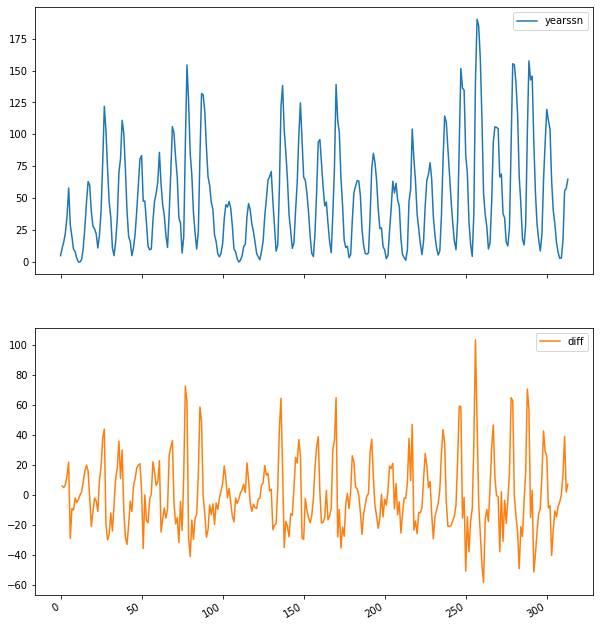

In [ ]:
# Differencing
data['diff'] = data['yearssn'].diff(periods=1)

data.plot(subplots=True, figsize=(10,12))
plt.show()



---



Applying Exponential Smoothening

In [ ]:
#List of least mse and mae
mseses=[]
msedes=[]
msetes=[]
maeses=[]
maedes=[]
maetes=[]

**Single Exponential Smoothing**

In [ ]:
#Defining Single Exponential Smoothing function ses
def ses(arr,alpha):
    arr1 = [arr[0]]
    for i in range(1, len(arr)):
        arr1.append(alpha * arr[i-1] + (1 - alpha) * arr1[i-1])
    return arr1

In [ ]:
#Defining Mean of Squared Error Function mse
def mse(arr1,arr2):
  arr3=[0]
  for i, j in zip(arr1, arr2):
    arr3.append(i-j)
  Sum=0
  for i in arr3:
    sqr=i**2
    Sum+=sqr
  mse=Sum/(len(arr2)-1)
  return mse

In [ ]:
#Function to make list of demand with interval 'n'
def dem_n(arr,n):
  arr1=[arr[0]]
  for i in range(1,len(arr)):
    if i%n==0:  
      arr1.append(arr[i])
  return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1423.7656094103215
Mean of Square Errors for alpha = 0.5 is:  1082.6052976072397
Mean of Square Errors for alpha = 0.8 is:  723.5052144698412


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8 is: ",mae3)

Mean Absolute Errors for alpha = 0.2 is:  31.04575551336873
Mean Absolute Errors for alpha = 0.5 is:  26.475409455479966
Mean Absolute Errors for alpha = 0.8 is:  20.66825223080585


alpha:  0.8


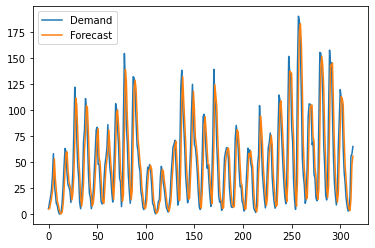

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])


**Double Exponential Smoothing**

In [ ]:
#Defining Double Exponential Smoothing function des
def des(arr,alpha,beta):
  a=[arr[0]]
  l=len(arr)
  b=[(arr[l-1]-arr[0])/(l-1)]
  arr1 = [arr[0]]
  arr1.append(a[0]+b[0])
  for i in range(1,len(arr)-1):
      a.append(alpha * arr[i] + (1 - alpha) * (a[i-1]+b[i-1]))
      b.append(beta * (a[i]-a[i-1]) + (1 - beta) * (b[i-1]))        
      arr1.append(a[i]+b[i])
  return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  2012.3303657557422
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1871.1571453106742
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  651.9662859611615


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3 is:  37.51233810681161
Mean Absolute Errors for alpha = 0.5,beta= 0.6 is:  34.0868149094099
Mean Absolute Errors for alpha = 0.8,beta= 0.9 is:  18.598707057177787


alpha:  0.8
beta:  0.9


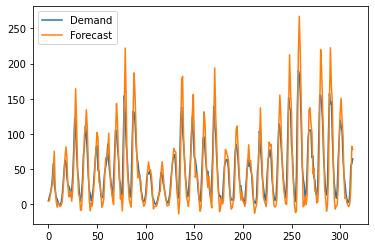

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])

**Triple Exponential Smoothing**

In [ ]:
#Defining initial trend
def initial_trend(arr, slen):
    Sum = 0
    for i in range(slen):
        Sum += float(arr[i+slen] - arr[i]) / slen
    return Sum / slen

In [ ]:
#Defining initial seasonal
def initial_seasonal(arr, slen):
    arr1 = {}
    s_avg = []
    m = int(len(arr)/slen)
    for j in range(m):
        s_avg.append(sum(arr[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        Sum = 0
        for j in range(m):
            Sum += arr[slen*j+i]-s_avg[j]
        arr1[i] = Sum/m
    return arr1

In [ ]:
#Defining Triple Exponential Smoothing function tes with interval 'n'
def tes(arr, slen, alpha, beta, gamma, n):
    arr1 = []
    seasonals = initial_seasonal(arr, slen)
    for i in range(len(arr)+n):
        if i == 0:
            smooth = arr[0]
            trend = initial_trend(arr, slen)
            arr1.append(arr[0])
            continue
        if i >= len(arr):
            m = i - len(arr) + 1
            arr1.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = arr[i]
            lsmooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-lsmooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            arr1.append(smooth+trend+seasonals[i%slen])
    return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  269.3844974223863
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  145.15574297524344
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  418.50971245836934


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  13.175520156294937
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  10.040754623873244
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  15.89153968520488


alpha:  0.5
beta:  0.6
gamma:  0.7


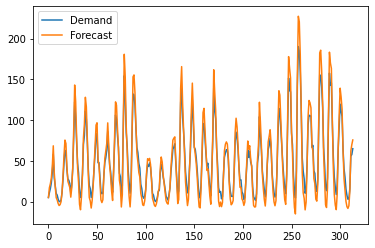

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])



---



For 1 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1423.7656094103215
Mean of Square Errors for alpha = 0.5 is:  1082.6052976072397
Mean of Square Errors for alpha = 0.8 is:  723.5052144698412


alpha:  0.8


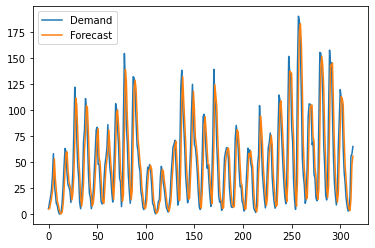

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  2012.3303657557422
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1871.1571453106742
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  651.9662859611615


alpha:  0.8
beta:  0.9


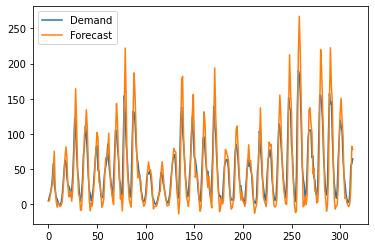

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  269.3844974223863
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  145.15574297524344
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  418.50971245836934


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  13.175520156294937
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  10.040754623873244
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  15.89153968520488


alpha:  0.5
beta:  0.6
gamma:  0.7


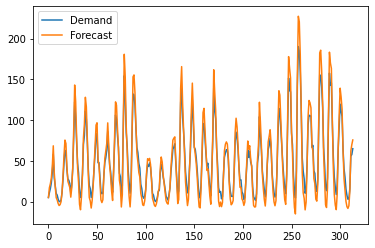

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 2 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1592.9627355629634
Mean of Square Errors for alpha = 0.5 is:  1766.7394603329508
Mean of Square Errors for alpha = 0.8 is:  1777.9034247112054


alpha:  0.2


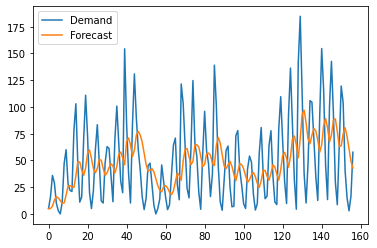

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  1795.1971208439209
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  2991.0663598929123
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  3526.6510703318286


alpha:  0.2
beta:  0.3


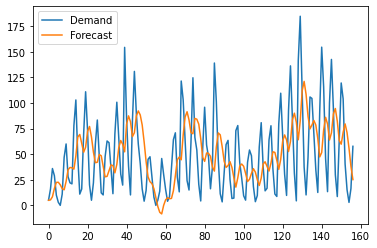

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  415.80390969219064
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  122.02948159950819
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  928.2878781682471


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  17.469677978838963
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  9.16547484168987
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  25.386925465863833


alpha:  0.5
beta:  0.6
gamma:  0.7


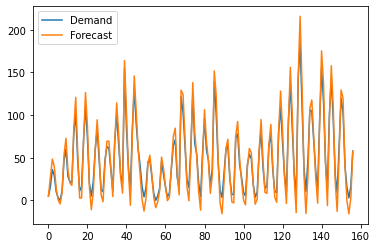

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 4 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1693.2449686568807
Mean of Square Errors for alpha = 0.5 is:  2134.9658263484116
Mean of Square Errors for alpha = 0.8 is:  2968.5190929519595


alpha:  0.2


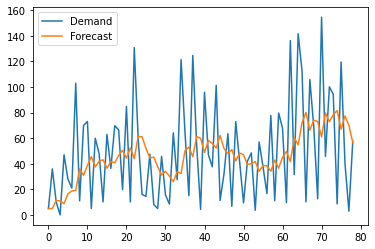

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  1861.7609770709907
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  2772.722713554847
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  6334.244971342228


alpha:  0.2
beta:  0.3


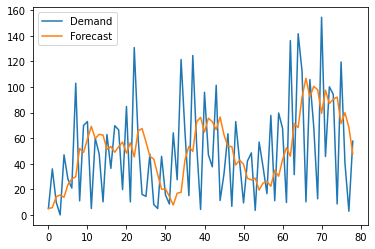

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  661.2049102216006
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  68.23978479971298
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  1328.0494076540465


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  21.224505551778854
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  6.345566663687334
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  30.327630901647133


alpha:  0.5
beta:  0.6
gamma:  0.7


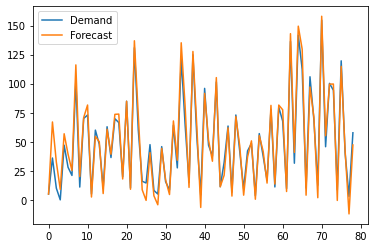

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 8 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1934.1154156697291
Mean of Square Errors for alpha = 0.5 is:  2210.233614294581
Mean of Square Errors for alpha = 0.8 is:  2567.196785297861


alpha:  0.2


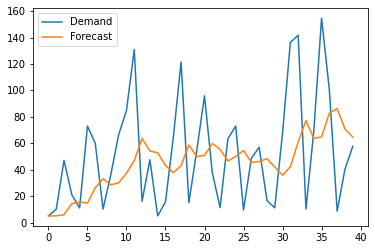

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  2200.2528825736854
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  3247.7380391296747
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  5501.475735494226


alpha:  0.2
beta:  0.3


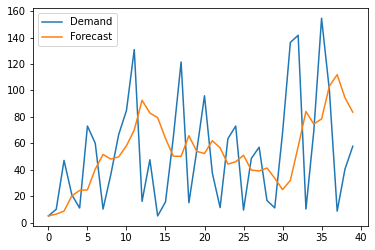

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  508.8331089708787
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  113.56662360267781
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  1250.4587420536172


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  17.555963491060538
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  8.534471665110216
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  27.862047208668308


alpha:  0.5
beta:  0.6
gamma:  0.7


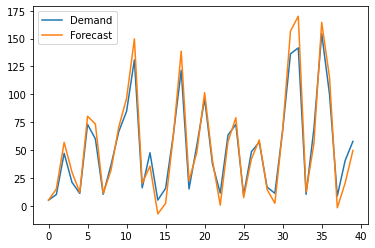

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 12 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1022.7884998909686
Mean of Square Errors for alpha = 0.5 is:  944.7411881574418
Mean of Square Errors for alpha = 0.8 is:  919.5444938370305


alpha:  0.8


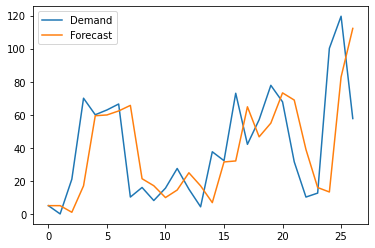

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  1230.7916334585705
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1420.1624307361178
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  1617.3042101904846


alpha:  0.2
beta:  0.3


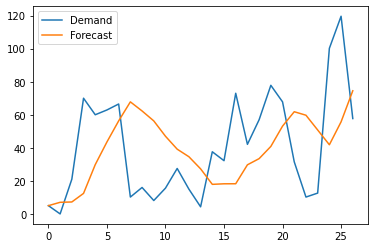

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  226.1821383063702
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  75.03413321281637
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  470.36206065866025


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  11.280765700782277
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  7.028383578100507
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  15.738301712859059


alpha:  0.5
beta:  0.6
gamma:  0.7


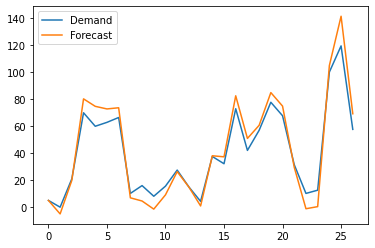

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 24 Interval

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  1039.7499684745346
Mean of Square Errors for alpha = 0.5 is:  1029.0628839029584
Mean of Square Errors for alpha = 0.8 is:  1206.0812286782327


alpha:  0.5


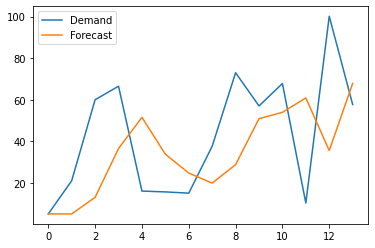

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  900.4246777371616
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1493.115190502541
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  2359.272425689149


alpha:  0.2
beta:  0.3


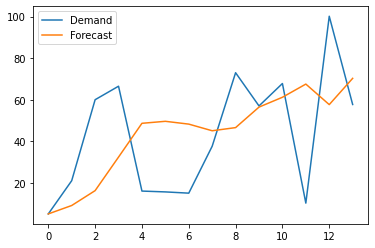

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.yearssn,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  493.35639407287624
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  108.60519673656229
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  586.7919040583805


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  18.219079669274702
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  8.096574869244506
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  19.03964964271159


alpha:  0.5
beta:  0.6
gamma:  0.7


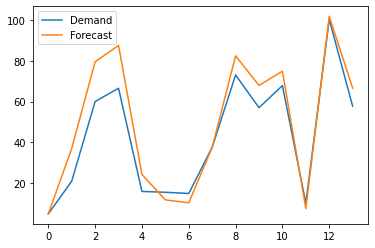

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)



---

Least MSE and MAE values are


In [ ]:
print("Least MSE ses")
print(mseses)
print("Least MSE des")
print(msedes)
print("Least MSE tes")
print(msetes)


print("Least MAE ses")
print(maeses)
print("Least MAE des")
print(maedes)
print("Least MAE tes")
print(maetes)


Least MSE ses
[723.5052144698412, 1592.9627355629634, 1693.2449686568807, 1934.1154156697291, 919.5444938370305, 1029.0628839029584]
Least MSE des
[651.9662859611615, 1795.1971208439209, 1861.7609770709907, 2200.2528825736854, 1230.7916334585705, 900.4246777371616]
Least MSE tes
[145.15574297524344, 122.02948159950819, 68.23978479971298, 113.56662360267781, 75.03413321281637, 108.60519673656229]
Least MAE ses
[10.040754623873244, 10.040754623873244, 9.16547484168987, 6.345566663687334, 8.534471665110216, 7.028383578100507]
Least MAE des
[10.040754623873244, 10.040754623873244, 9.16547484168987, 6.345566663687334, 8.534471665110216]
Least MAE tes
[10.040754623873244, 9.16547484168987, 6.345566663687334, 8.534471665110216, 7.028383578100507, 8.096574869244506]




---



Applying ACF and PACF

<function matplotlib.pyplot.show>

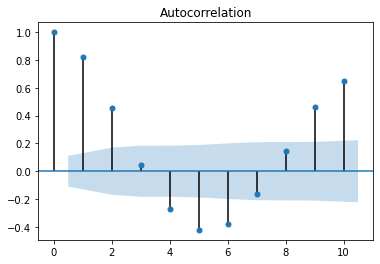

In [ ]:
#Plotting ACF
plot_acf(data.yearssn,lags=10)
plt.show

<function matplotlib.pyplot.show>

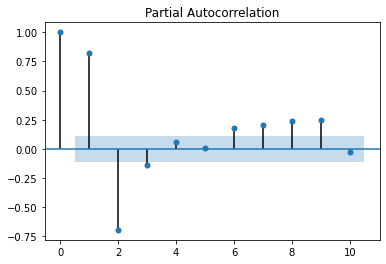

In [ ]:
#plotting PACF
plot_pacf(data.yearssn,lags=10)
plt.show



---



Applying AR, MA, ARIMA Models

                              ARMA Model Results                              
Dep. Variable:                yearssn   No. Observations:                  314
Model:                     ARMA(3, 0)   Log Likelihood               -1325.144
Method:                       css-mle   S.D. of innovations             16.401
Date:                Mon, 01 Mar 2021   AIC                           2660.287
Time:                        05:35:08   BIC                           2679.034
Sample:                             0   HQIC                          2667.778
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.6160      2.750     18.045      0.000      44.227      55.005
ar.L1.yearssn     1.2973      0.056     23.217      0.000       1.188       1.407
ar.L2.yearssn    -0.5035      0.088     

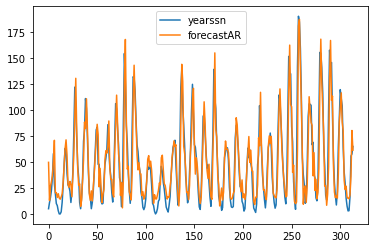

In [ ]:
#AR

#fit model
model=ARIMA(data['yearssn'], order=(3,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastAR'] = model_fit.predict()
data[['yearssn','forecastAR']].plot()

In [ ]:
mse=mean_squared_error(data.yearssn,data.forecastAR.dropna())
print("MSE for AR is:",mse)

MSE for AR is: 274.28824978825946


In [ ]:
mae=mean_absolute_error(data.yearssn,data.forecastAR.dropna())
print("MAE for AR is:",mae)

MAE for AR is: 12.526751800100925


                              ARMA Model Results                              
Dep. Variable:                   diff   No. Observations:                  313
Model:                     ARMA(0, 2)   Log Likelihood               -1373.226
Method:                       css-mle   S.D. of innovations             19.445
Date:                Mon, 01 Mar 2021   AIC                           2754.451
Time:                        05:35:08   BIC                           2769.436
Sample:                             0   HQIC                          2760.439
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2146      2.147      0.100      0.920      -3.994       4.423
ma.L1.diff     0.6232      0.053     11.680      0.000       0.519       0.728
ma.L2.diff     0.3345      0.050      6.714      0.0

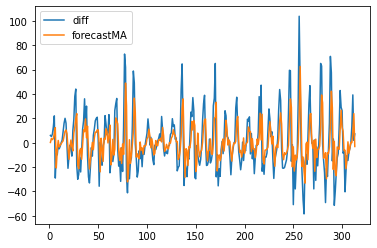

In [ ]:
#MA

#fit model
model=ARIMA(data['diff'].dropna(), order=(0,0,2))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastMA'] = model_fit.predict()
data[['diff','forecastMA']].plot()

In [ ]:
mse=mean_squared_error(data.yearssn[0:-1],data.forecastMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 4074.783133969069


In [ ]:
mae=mean_absolute_error(data.yearssn[0:-1],data.forecastMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 49.34682101981897


                              ARMA Model Results                              
Dep. Variable:                   diff   No. Observations:                  313
Model:                     ARMA(3, 2)   Log Likelihood               -1301.544
Method:                       css-mle   S.D. of innovations             15.404
Date:                Mon, 01 Mar 2021   AIC                           2617.089
Time:                        05:35:09   BIC                           2643.312
Sample:                             0   HQIC                          2627.568
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.405      0.026      0.979      -0.784       0.805
ar.L1.diff     1.8040      0.084     21.420      0.000       1.639       1.969
ar.L2.diff    -1.2407      0.131     -9.477      0.0

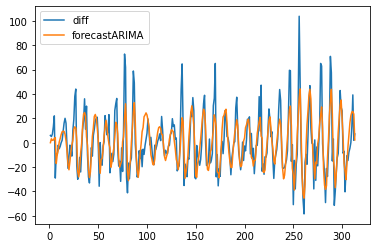

In [ ]:
#ARIMA

#fit model
model=ARIMA(data['diff'].dropna(), order=(3,0,2))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastARIMA'] = model_fit.predict()
data[['diff','forecastARIMA']].plot()

In [ ]:
mse=mean_squared_error(data.yearssn[0:-1],data.forecastARIMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 4854.11167302186


In [ ]:
mae=mean_absolute_error(data.yearssn[0:-1],data.forecastARIMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 52.499355713783395




---



Applying Auto ARIMA

In [ ]:
import pmdarima as pm
model = pm.auto_arima(data.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2779.644, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3503.280, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2878.675, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3162.801, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2743.327, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2744.118, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2748.118, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2734.757, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2738.506, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2629.302, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2738.753, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2736.348, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2663.070, Time=0.76 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 2.386 seconds
                      

# Best model:  ARIMA(3,0,2)(0,0,0)[0]          


Final Result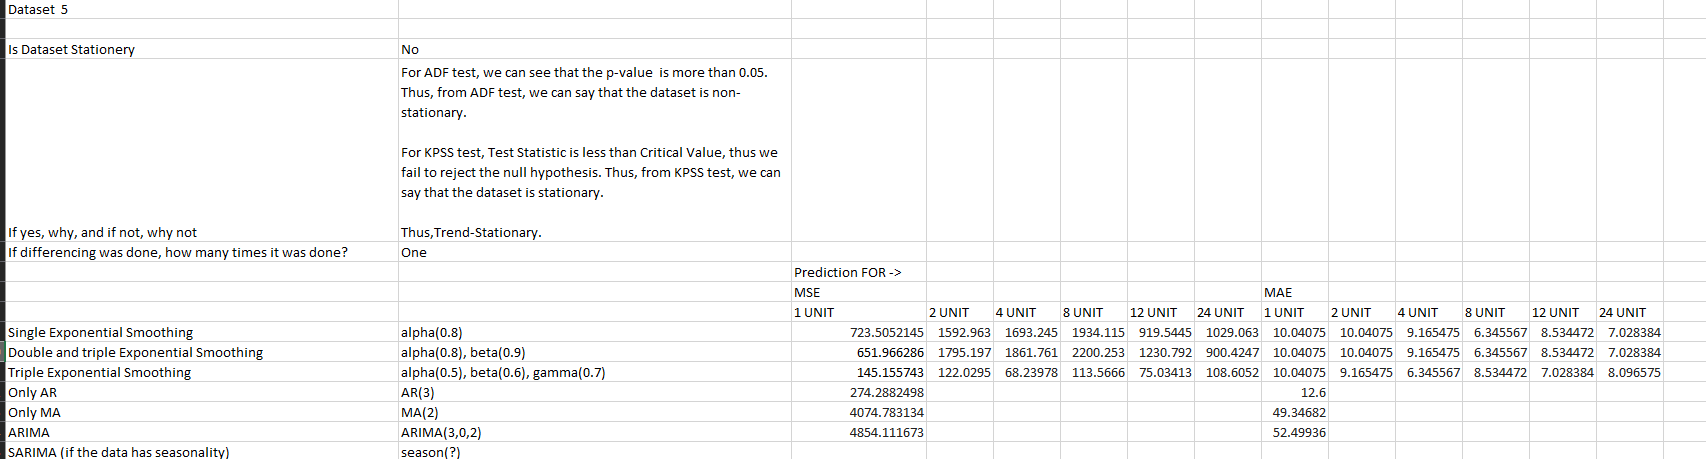